# Giai đoạn 1 – SSIM + Histogram + Layout (2 lớp)

In [3]:
import cv2, os, re
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix

def load_cases():
    mapping = {
        'identical': 'similar',
        'font_color': 'similar',        
        'text_changes': 'different',
        'layout_changes': 'different',
        'changes': 'different',
        'completely_different': 'different'
    }
    cases, groups = [], []
    ori_dir = "Pictures_VisualTesting/original_image/"
    var_dir = "Pictures_VisualTesting/variant_image/"

    for f in os.listdir(ori_dir):
        m = re.search(r'original_(\d+)', f)
        if not m:
            continue
        group_id = int(m.group(1))
        vidir = os.path.join(var_dir, f"original_{m.group(1)}")
        if not os.path.isdir(vidir):
            continue
        for vf in os.listdir(vidir):
            label_name = vf.split('.')[0].lower()  
            label = mapping.get(label_name)
            if label:
                cases.append((os.path.join(ori_dir, f), os.path.join(vidir, vf), label))
                groups.append(group_id)
    return cases, groups

class Ver_1_SVM:
    def __init__(self, C = 1.0, kernel = 'linear'):
        self.scaler = StandardScaler()
        self.model = SVC(
            kernel = kernel,
            C = C,
            random_state = 42
        )
        self.map = {'similar': 0, 'different': 1}
        self.names = ['Similar', 'Different']

    def prep_gray(self, img):
        g = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        if g is None: return None
        max_pixels = 700_000
        h, w = g.shape
        if h * w > max_pixels:
            s = (max_pixels/(h*w))**0.5
            g = cv2.resize(g, (int(w*s), int(h*s)))
        g = cv2.medianBlur(g,3)
        return g
    
    def ensure_same_size(self, g1, g2):
        if g1 is None or g2 is None: return None, None
        if g1.shape == g2.shape: return g1, g2
        h1, w1 = g1.shape
        g2 = cv2.resize(g2, (w1, h1)) 
        return g1, g2

    def ssim(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            return ssim(g1, g2, data_range=255)
        except: return 0.5

    def hist(self, a, b):
        try:
            c1 = cv2.imread(a); c2 = cv2.imread(b)
            if c1 is None or c2 is None: return 0.5
            max_pixels = 450_000
            def shrink(img):
                h,w = img.shape[:2]
                if h*w <= max_pixels: return img
                s = (max_pixels/(h*w))**0.5
                return cv2.resize(img,(int(w*s), int(h*s)))
            c1, c2 = shrink(c1), shrink(c2)
            sims = []
            bins = 32
            for ch in range(3):
                h1 = cv2.calcHist([c1],[ch],None,[bins],[0,256])
                h2 = cv2.calcHist([c2],[ch],None,[bins],[0,256])
                cv2.normalize(h1,h1,alpha=1.0,norm_type=cv2.NORM_L1)
                cv2.normalize(h2,h2,alpha=1.0,norm_type=cv2.NORM_L1)
                sims.append((cv2.compareHist(h1,h2,cv2.HISTCMP_CORREL)+1)/2)
            return float(np.mean(sims))
        except:
            return 0.5

    def layout(self, a, b):
        try:
            g1 = self.prep_gray(a)
            g2 = self.prep_gray(b)
            g1, g2 = self.ensure_same_size(g1, g2)
            if g1 is None or g2 is None: return 0.5
            e1 = cv2.Canny(g1, 50, 150) > 0
            e2 = cv2.Canny(g2, 50, 150) > 0
            inter = np.logical_and(e1, e2).sum()
            uni = np.logical_or(e1, e2).sum()
            if uni == 0: return 1.0
            return float(inter/uni)
        except: 
            return 0.5

    def feat(self, a, b):
        return [
            self.ssim(a, b),
            self.hist(a, b),
            self.layout(a, b)
        ]

    def train_eval(self, cases, groups):
        X = [self.feat(a, b) for a, b, _ in cases]
        y = [self.map[l] for _, _, l in cases]

        from collections import Counter
        label_counts = Counter([label for _, _, label in cases])
        print("Label distribution:", dict(label_counts))

        gkf = GroupKFold(n_splits=5)
        accuracies = []
        fold = 1

        for train_idx, test_idx in gkf.split(X, y, groups):
            print(f"\n===== Fold {fold} =====")
            Xtr = [X[i] for i in train_idx]
            ytr = [y[i] for i in train_idx]
            Xte = [X[i] for i in test_idx]
            yte = [y[i] for i in test_idx]

            self.scaler.fit(Xtr)
            self.model.fit(self.scaler.transform(Xtr), ytr)
            yp = self.model.predict(self.scaler.transform(Xte))

            acc = (yp == yte).mean() * 100
            accuracies.append(acc)
            print(f"Accuracy: {acc:.2f}%")
            print(classification_report(yte, yp, target_names=self.names))
            print(confusion_matrix(yte, yp))
            fold += 1

        print(f"\nMean Accuracy: {np.mean(accuracies):.1f}%")
        print(f"Std Accuracy: {np.std(accuracies):.1f}%")
        
        return np.mean(accuracies), np.std(accuracies)

cases, groups = load_cases()
print(f"{len(cases)} cases from {len(set(groups))} groups")
v1_model = Ver_1_SVM()  
v1_mean, v1_std = v1_model.train_eval(cases, groups)

360 cases from 60 groups
Label distribution: {'different': 240, 'similar': 120}

===== Fold 1 =====
Accuracy: 77.78%
              precision    recall  f1-score   support

     Similar       0.68      0.62      0.65        24
   Different       0.82      0.85      0.84        48

    accuracy                           0.78        72
   macro avg       0.75      0.74      0.74        72
weighted avg       0.77      0.78      0.78        72

[[15  9]
 [ 7 41]]

===== Fold 2 =====
Accuracy: 80.56%
              precision    recall  f1-score   support

     Similar       0.73      0.67      0.70        24
   Different       0.84      0.88      0.86        48

    accuracy                           0.81        72
   macro avg       0.78      0.77      0.78        72
weighted avg       0.80      0.81      0.80        72

[[16  8]
 [ 6 42]]

===== Fold 3 =====
Accuracy: 79.17%
              precision    recall  f1-score   support

     Similar       0.71      0.62      0.67        24
   Diffe

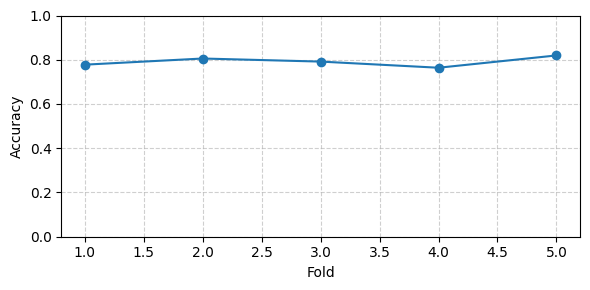

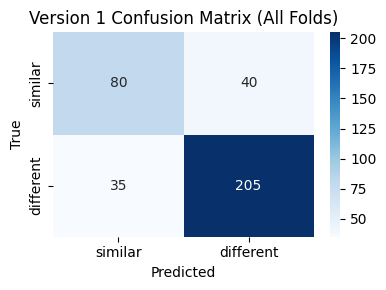

In [4]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix, accuracy_score

def build_feature_df(feat_extractor, cases, groups):
    rows = []
    for (a,b,l), g in zip(cases, groups):
        f = feat_extractor.feat(a,b)
        cols = ['SSIM','OCR','Hist','ORB','Layout'] if len(f)==5 else \
               ['SSIM','OCR','Hist','Layout'] if len(f)==4 else \
               ['SSIM','Hist','Layout'] if len(f)==3 else ['SSIM']
        row = {c:v for c,v in zip(cols,f)}
        row['label'] = l
        row['group'] = g
        rows.append(row)
    return pd.DataFrame(rows)

if 'df_v1' not in globals():
    df_v1 = build_feature_df(v1_model, [(a,b,l) for a,b,l in cases], groups)

feat_cols = ['SSIM','Hist','Layout']

groups_v1 = df_v1['group'].to_numpy()          
assert len(df_v1) == len(groups_v1)
gkf=GroupKFold(n_splits=5)
accs=[]; all_true=[]; all_pred=[]

for tr, te in gkf.split(df_v1, df_v1['label'], groups_v1):
    Xtr = df_v1.iloc[tr][feat_cols].values
    Xte = df_v1.iloc[te][feat_cols].values
    ytr = df_v1.iloc[tr]['label'].map(v1_model.map).values
    yte_lab = df_v1.iloc[te]['label'].values
    v1_model.scaler.fit(Xtr)
    v1_model.model.fit(v1_model.scaler.transform(Xtr), ytr)
    yp = v1_model.model.predict(v1_model.scaler.transform(Xte))
    yp_lab = np.where(yp==0, 'similar', 'different')
    accs.append(accuracy_score(yte_lab, yp_lab))
    all_true.extend(yte_lab)
    all_pred.extend(yp_lab)

plt.figure(figsize=(6,3))
plt.plot(range(1,len(accs)+1), accs, marker='o')
plt.xlabel('Fold'); plt.ylabel('Accuracy')
plt.ylim(0,1); plt.grid(ls='--',alpha=.6)
plt.tight_layout()
plt.show()

cm=confusion_matrix(all_true, all_pred, labels=['similar','different'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['similar','different'], yticklabels=['similar','different'])
plt.title('Version 1 Confusion Matrix (All Folds)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.show()